## Homework 8

In the first problem I want you to think about loss functions for binary data. The second exercise prepares you for the "multinomial" case where we have more than 2 categories as outcome.

1. Fit a logistic regression `default ~ balance` to a random subset of 1000 rows of the default data from the ISLR library.
    * Predict the default probability on a regular array of balance values between on the interval $[0; 3000]$ and plot the resulting sigmoid-shaped curve.
    * Find those 4 balances which yield predicted probabilities (closest to) $\hat{p} = [0.5, 0.05, 0.005, 0.0005]$. 
    * Overlay these 4 points on the plot with a y value of $default=1$ (yes).
    * Compute the following loss functions for each of the four $(y_i, \hat{p}_i)$ pairs and dicsuss their merits/shortcomings:
        * Squared Error: $(y_i - \hat{p}_i)^2$
        * Log Loss: $y_i \cdot \log{\hat{p}_i}$
        * Hinge: `np.max(0, 1 - pHat * y)`
        * Accuracy: $y_i == (\hat{p}_i > 0.5)$
2. Multiclass logistic regression: The iris data set contains data on 3 flower types: "setosa", "versicolor", "virginica" (coded as integers $0, 1, 2$). 
    * Fit 3 separate logistic regressions with the binary outcome set to one flower type versus the others.
    * How could you combine these 3 models into one ?
    * Think about possible shortomings of this "one verus the rest" strategy.


------

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

### 1. 

In [2]:
df = pd.read_excel('../../Data/Default.xlsx', index_col=0)

df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB


In [4]:
df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


In [5]:
df_sample = df.sample(n=1000, random_state=1)
df_sample["default"].value_counts()

No     967
Yes     33
Name: default, dtype: int64

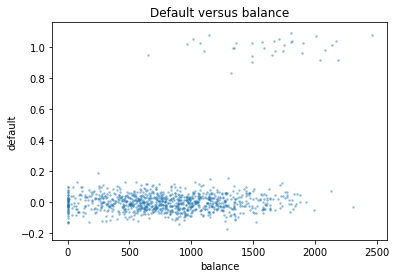

In [6]:
# add jitter to your plot:
N = df_sample.shape[0]
df_sample["default_bool"] = df_sample["default"] == "Yes"
df_sample["default_jitter"] = df_sample["default_bool"] + 0.05*np.random.randn(N)
plt.scatter(df_sample["balance"], df_sample["default_jitter"], s=2.5, alpha=0.35)
plt.xlabel('balance')
plt.ylabel('default')
plt.title('Default versus balance')
plt.show()

#### Fitting a Logistic Regression

In [7]:
sample_x = np.array(df_sample['balance']).reshape(-1,1)
sample_y = np.array(df_sample['default_bool'])

model = LogisticRegression()
model.fit(sample_x, sample_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Predicting Probability & Plotting Curve

In [8]:
x_test = np.array(df['balance'].iloc[:3000]).reshape(-1,1)
y_test = (df['default'] == 'Yes').iloc[:3000]

pred_prob = model.predict_proba(x_test)
pred_prob[:5]

array([[0.99585856, 0.00414144],
       [0.99402256, 0.00597744],
       [0.98262385, 0.01737615],
       [0.99821259, 0.00178741],
       [0.99476117, 0.00523883]])

Balance Threshold: 2033.19


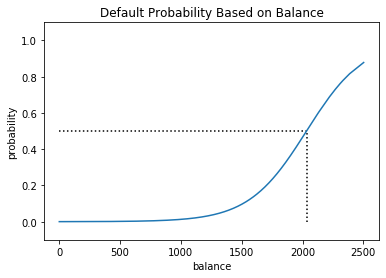

In [9]:
x_test_prob = pd.DataFrame({'balance': x_test.ravel(), 'default_prob': pred_prob[:,1]}).sort_values('balance')

find_closest_value_index = lambda array, value: (np.abs(array - value)).argmin()

balance_threshold = x_test_prob['balance'].iloc[find_closest_value_index(x_test_prob['default_prob'], 0.5)]
print('Balance Threshold: {}'.format(round(balance_threshold, 2)))

plt.plot(x_test_prob['balance'], x_test_prob['default_prob'])
plt.ylim(-0.1,1.1)
plt.title('Default Probability Based on Balance')
plt.xlabel('balance')
plt.ylabel('probability')
plt.hlines(0.5, 0, balance_threshold, linestyles='dotted')
plt.vlines(balance_threshold, 0, 0.5, linestyles='dotted')

#### Find Balances According to Probabilities

In [10]:
probs = [0.5, 0.05, 0.005, 0.0005]
balances = []

for prob in probs:
    balance = x_test_prob['balance'].iloc[find_closest_value_index(x_test_prob['default_prob'], prob)]
    balances.append(balance)
    
pd.DataFrame({'probability': probs, 'balance': balances})

,probability,balance
0,0.5000,2033.191790
1,0.0500,1332.782564
2,0.0050,774.413837
3,0.0005,226.417697


#### Overlay Points with Default = True

Text(0, 0.5, 'probability')

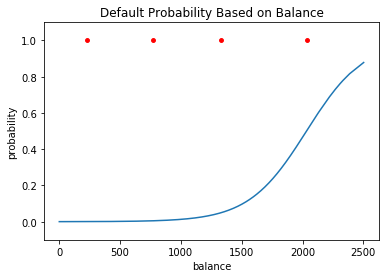

In [11]:
plt.plot(x_test_prob['balance'], x_test_prob['default_prob'])
for val in balances:
    plt.scatter(val, 1, c='r', s=15)
plt.ylim(-0.1,1.1)
plt.title('Default Probability Based on Balance')
plt.xlabel('balance')
plt.ylabel('probability')

#### Compute and Discuss Loss Functions

In [12]:
y_true_list = []

for val in balances:
    default = df['default'][df['balance'] == val]
    y_true_list.append(default.values[0] == 'Yes')
    
true_data = pd.DataFrame({'balance': balances, 'default': y_true_list})
true_data

,balance,default
0,2033.191790,True
1,1332.782564,False
2,774.413837,False
3,226.417697,False


- Squared Error

There are two main reasons why the Squared Error is not a good loss function to use in Logistic Regression: 

1. The maximum penalty for a wrong prediction is 1, for example if a true value is 1 and the prediction is 0, this means: $(1 - 0)^2 = 1$; and the other way around, if the true value is 0 and the prediction is 1: $(0 - 1)^2 = 1$. It would be better to have a loss function that would penalize more wrong predictions, than just to measure distance, because in this case there is not a lot to measure, even when the prediction is totally wrong.  

2. When we have a loss function, we always want to minimize it. In order to minimize a function, it is a lot easier when the function is convex. In the case of using the Squared Error for Logistic Regression, the function is no longer convex, because of the sigmoid transformation performed on the predicted values. This is why this loss function works well with Linear Regression, but not with Logistic Regression, as when minimizing it, we are not sure if we will be able to find the global minimum. 

Squared Error:
0.25
0.0025
2.5e-05
2.5e-07


Text(0.5, 1.0, 'Squared Error Function in Logistic Regression (Not Convex)')

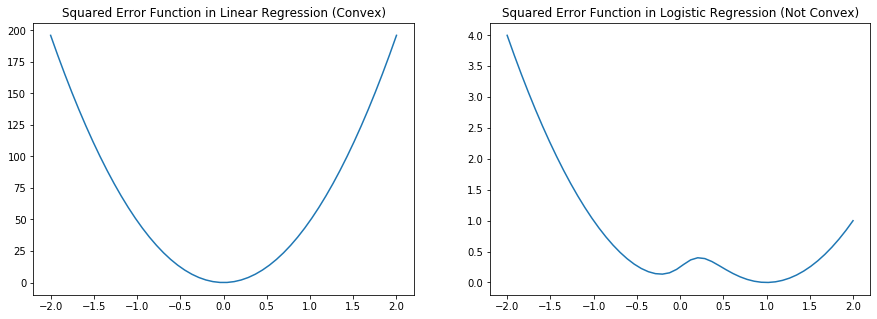

In [13]:
print('Squared Error:')
for i in range(len(probs)):
    y_true = y_true_list[i]
    y_pred = probs[i]
    squared_error = (y_true - y_pred)**2
    print(round(squared_error,8))
 
beta = 8
x_values = np.linspace(-2, 2)

error_func_linear = lambda x, beta: (x - x*beta)**2
y_values_linear = error_func_linear(x_values, beta)

error_func_sigmoid = lambda x, beta: (x - 1/(1+np.exp(-(x*beta))))**2
y_values_sigmoid = error_func_sigmoid(x_values, beta)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(x_values, y_values_linear)
plt.title('Squared Error Function in Linear Regression (Convex)')

plt.subplot(1,2,2)
plt.plot(x_values, y_values_sigmoid)
plt.title('Squared Error Function in Logistic Regression (Not Convex)')

- Log Loss

This is the most common loss function used in Logistic Regression. We could say that it is a combination of two functions, as depending on the true 'y' value, the function behaves differently. One advantage is that this loss function not only penalizes on wrong predictions, but also on the certainty of this wrong prediction. This means that if a true 'y' value is 1, the closer the probability is to zero, the larger the penalty, as the function quickly grows towards infinity; the same happens if a true 'y' value is 0, the closer the probability is to 1, the higher the penalty. Basically, the farther away the probabilities are from the true value, the larger the penalty will be as the functions grows to infinity.


Log Loss:
0.69314718
0.05129329
0.00501254
0.00050013


D:\Users\Joshua\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


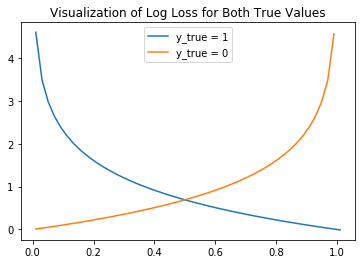

In [14]:
print('\nLog Loss:')
for i in range(len(probs)):
    y_true = y_true_list[i]
    y_pred = probs[i]
    log_loss = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    print(round(log_loss, 8))
   
x_values = np.linspace(0.01,1.01)
log_loss_func_1 = lambda x: -np.log(x_values)
log_loss_func_0 = lambda x: -np.log(1 - x_values)

plt.plot(x_values, log_loss_func_1(x_values), label='y_true = 1')
plt.plot(x_values, log_loss_func_0(x_values), label='y_true = 0')
plt.title('Visualization of Log Loss for Both True Values')
plt.legend()

- Hinge Loss

This loss function is mostly used in Support Vector Machines. It might not be a good idea to use it for Logistic Regression as the function expects class labels of [-1,1], so the labels of [0,1] will not work correctly. We can see this happening in the three last examples of our loss computations, where we have a result of 1, even though our prediction was correct with class 0. This happens because for the right part of the hinge function, "1 - (0 * 0) = 1", so we penalize incorrectly; however if our class was -1 instead of 0, it would be "1 - (-1 * -1) = 0", which would be the correct loss for a correct prediction. 

We could use this loss function for Logistic Regression if we scale our results to be between [-1,1], which seems to work.

Hinge Without Normalization:
0.5
1.0
1.0
1.0

Hinge With Normalization:
1.0
0.1
0.01
0.001


Text(0.5, 1.0, 'Visualization of Hinge Loss')

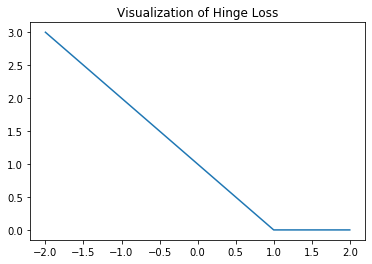

In [15]:
print('Hinge Without Normalization:')
for i in range(len(probs)):
    y_true = y_true_list[i]
    y_pred = probs[i]
    hinge = np.max([0, 1 - y_pred * y_true])
    print(hinge)
    
data_for_scaling = [[1], [1], [0], [0]]
scaler = StandardScaler()
scaler.fit(data_for_scaling)
scaled_defaults = scaler.transform(np.array(true_data['default']).reshape(-1,1))
scaled_probs = scaler.transform(np.array(probs).reshape(-1,1))

print('\nHinge With Normalization:')
for i in range(len(probs)):
    y_true = scaled_defaults[i]
    y_pred = scaled_probs[i]
    hinge = np.max([0, 1 - y_pred * y_true])
    print(round(hinge[0], 5))
    
x_values = np.linspace(-2, 2, num=5)
y_values = np.empty(x_values.shape)
for i in range(len(x_values)): 
    y_values[i] = np.max([0, 1 - x_values[i]])
    
plt.plot(x_values, y_values)
plt.title('Visualization of Hinge Loss')

- Accuracy

This is not a loss function, but a score function, so we would try to maximize it, instead of minimizing it. It is a good function to understand better the performance of the model, however it should be used together with other functions, as it has strong drawbacks. For example, if we have a dataset with 100 samples, 20 belong to class 'A' and 80 belong to class 'B', and we decide to predict that all the samples are class 'B' we would have 80% accuracy, which is a good score, but it doesn't show how bad the model is; that's why it's a good idea to understand and know the data before depending only on this score. It's good to use the accuracy score together with confusion matrices, recall and precision scores, to understand really the performance of the model. 

In [16]:
print('\nAccuracy:')
for i in range(len(probs)):
    y_true = y_true_list[i]
    y_pred = probs[i]
    accuracy = y_true == (y_pred > 0.05)
    print(accuracy)


Accuracy:
True
True
True
True


### Multinomial LR

The iris data:

In [17]:
from sklearn import datasets

iris = datasets.load_iris()

flower_types = iris['target_names']

X_iris = pd.DataFrame(iris['data'], columns=['sepal_length','sepal_width','petal_length','petal_width'])
y_iris = pd.get_dummies(pd.DataFrame(list(map(lambda x: flower_types[x], iris['target'])), columns=['target']))

X_iris.join(y_iris).head()

,sepal_length,sepal_width,petal_length,petal_width,target_setosa,target_versicolor,target_virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


#### Logistic Regression on Setosa Flowers

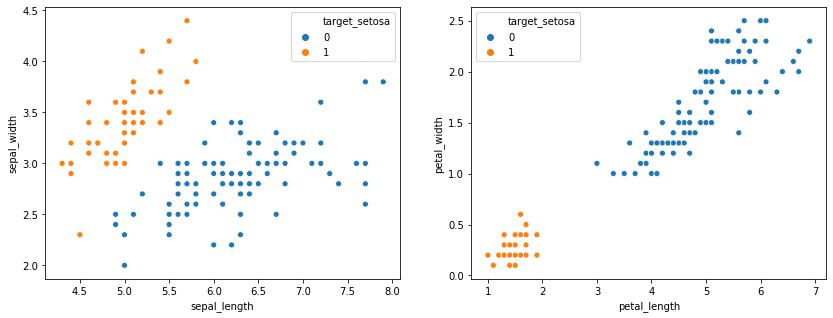

In [18]:
y_setosa = y_iris['target_setosa']

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.scatterplot(X_iris['sepal_length'], X_iris['sepal_width'], hue=y_setosa)
plt.subplot(1,2,2)
sns.scatterplot(X_iris['petal_length'], X_iris['petal_width'], hue=y_setosa)

In [19]:
model_setosa = LogisticRegression()
model_setosa.fit(X_iris, y_setosa)
score = model_setosa.score(X_iris, y_setosa)

print('Model Training Accuracy: {}'.format(score))
print('\nConfusion Matrix:\n{}'.format(confusion_matrix(y_setosa, model_setosa.predict(X_iris))))

Model Training Accuracy: 1.0

Confusion Matrix:
[[100   0]
 [  0  50]]


#### Logistic Regression on Versicolor Flower

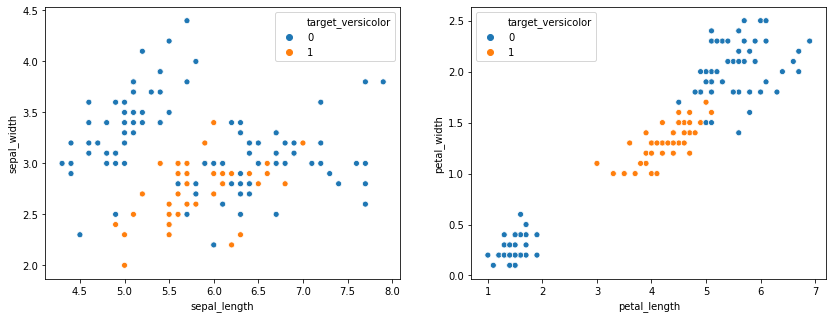

In [20]:
y_versicolor = y_iris['target_versicolor']

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.scatterplot(X_iris['sepal_length'], X_iris['sepal_width'], hue=y_versicolor)
plt.subplot(1,2,2)
sns.scatterplot(X_iris['petal_length'], X_iris['petal_width'], hue=y_versicolor)

In [21]:
model_versicolor = LogisticRegression()
model_versicolor.fit(X_iris, y_versicolor)
score = model_versicolor.score(X_iris, y_versicolor)

print('Model Training Accuracy:\n{}'.format(round(score,2)))
print('\nConfusion Matrix:\n{}'.format(confusion_matrix(y_versicolor, model_versicolor.predict(X_iris))))

Model Training Accuracy:
0.73

Confusion Matrix:
[[88 12]
 [29 21]]


#### Logistic Regression on Virginica

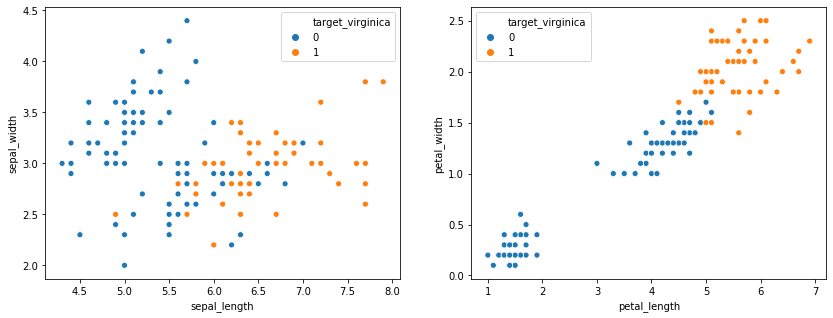

In [22]:
y_virginica = y_iris['target_virginica']

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.scatterplot(X_iris['sepal_length'], X_iris['sepal_width'], hue=y_virginica)
plt.subplot(1,2,2)
sns.scatterplot(X_iris['petal_length'], X_iris['petal_width'], hue=y_virginica)

In [23]:
model_virginica = LogisticRegression()
model_virginica.fit(X_iris, y_virginica)
score = model_virginica.score(X_iris, y_virginica)

print('Model Training Accuracy:\n{}'.format(round(score,2)))
print('\nConfusion Matrix:\n{}'.format(confusion_matrix(y_virginica, model_virginica.predict(X_iris))))

Model Training Accuracy:
0.97

Confusion Matrix:
[[97  3]
 [ 1 49]]


#### Combining Three Models into One

In order to have do a multiclass Logistic Regression, you can do an All vs. Rest approach, which is what we did above, by training a different model for each different class, i.e. [setosa] vs. [versicolor, virginica], [versicolor] vs. [setosa, virginica], [virginica] vs. [setosa, versicolor]. We can do this process manually, and then when we have to predict on new data, we predict using the three models, and choose the model and corresponding class that gives the highest probability. If we don't want to do it manually, we can use the 'liblinear' solver within sklearn's Logistic Regression, which is the only one limited to one-versus-rest schemes.

In [24]:
multinomial_lr = LogisticRegression(solver='liblinear')
multinomial_lr.fit(X_iris, iris['target'])
print('Training Accuracy Score:')
multinomial_lr.score(X_iris, iris['target'])

Training Accuracy Score:


0.96

Another option to do a multiclass Logistic Regression is to use the other solvers within sklearn's Logistic Regression, like 'newton-cg', 'sag', 'saga' and 'lbgfs', which handle multinomial loss, and looks like perform a little better with default parameters. 

In [25]:
multinomial_lr = LogisticRegression(solver='newton-cg', multi_class='multinomial')
multinomial_lr.fit(X_iris, iris['target'])
print('Training Accuracy Score:')
round(multinomial_lr.score(X_iris, iris['target']), 2)

Training Accuracy Score:


0.97

#### Shortcomings of One vs. Rest Strategy

Let's say we have a dataset with millions of records, hundreds of features, and many different classes. We would have to fit this huge dataset over and over again for each different class, which could take quite a long time; after this, if we want to predict on new data, we would have to predict using all the different models and choose the best one. In general, this approach might not be the most efficient way to do it; it would be better to use a more powerful solver or another algorithm. 